# Imports and Constants

In [1]:
import h5py
import numpy as np
import pandas as pd
import os
from collections import Counter
from collections import defaultdict
import itertools

import glob
from tqdm.notebook import tqdm, trange

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
MODEL_TYPE = "resnet_e2e"
PATH_TO_PREDS = f"/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/model_out/preds/{MODEL_TYPE}.csv"

In [3]:
PATH_TO_RAW_DATA = "/deep/group/aihc-bootcamp-fall2021/lymphoma/raw"
PATH_TO_TRAIN_TEST_SPLIT = os.path.join(PATH_TO_RAW_DATA, "train_test_split.csv")
PATH_TO_DIAGNOSES = os.path.join(PATH_TO_RAW_DATA, "core_labels.csv")
TMA_ID = "TMA ID"
CASE = "CASE"
LABEL = "label"

# Load and Aggregate Predictions with Max-voting

In [4]:
model_preds_df = pd.read_csv(PATH_TO_PREDS)[["cores", "patch_num", "pred"]]

In [5]:
model_preds_df.drop('patch_num', axis=1, inplace=True)

In [6]:
model_preds_df

,cores,pred
0,tma_1_E0006 B_v1,0
1,tma_1_E0006 B_v1,0
2,tma_1_E0006 B_v1,0
3,tma_1_E0006 B_v1,0
4,tma_1_E0006 B_v1,0
...,...,...
53828,tma_8_E0986B_v2,4
53829,tma_8_E0986B_v2,4
53830,tma_8_E0986B_v2,6
53831,tma_8_E0986B_v2,0


In [7]:
def mode1(s):
    l = s.value_counts().index.to_list()
    return l[0]

def mode2(s):
    l = s.value_counts().index.to_list()
    if len(l) < 2:
        return -1
    else:
        return l[1]
    
def mode3(s):
    l = s.value_counts().index.to_list()
    if len(l) < 3:
        return -1
    else:
        return l[2]

core_preds_df = model_preds_df.groupby("cores").agg([mode1, mode2, mode3]).reset_index()
core_preds_df.columns = ["cores"] + ['_'.join(col) for col in core_preds_df.columns][1:]

In [8]:
core_preds_df

,cores,pred_mode1,pred_mode2,pred_mode3
0,tma_1_E0006 B_v1,0,-1,-1
1,tma_1_E0011 B_v1,0,5,1
2,tma_1_E0011 B_v2,5,1,3
3,tma_1_E0017 B_v1,0,3,7
4,tma_1_E0017 B_v2,0,3,7
...,...,...,...,...
272,tma_8_E0983B_v1,6,1,0
273,tma_8_E0985B_v1,6,1,0
274,tma_8_E0985B_v2,6,0,-1
275,tma_8_E0986B_v1,0,6,4


In [9]:
core_preds_df["tma_id"] = core_preds_df["cores"].apply(lambda s: s[:5].replace("_", ""))
core_preds_df["patient_id"] = core_preds_df["cores"].apply(lambda s: s[6:-3].replace(" ", ""))

In [10]:
core_preds_df

,cores,pred_mode1,pred_mode2,pred_mode3,tma_id,patient_id
0,tma_1_E0006 B_v1,0,-1,-1,tma1,E0006B
1,tma_1_E0011 B_v1,0,5,1,tma1,E0011B
2,tma_1_E0011 B_v2,5,1,3,tma1,E0011B
3,tma_1_E0017 B_v1,0,3,7,tma1,E0017B
4,tma_1_E0017 B_v2,0,3,7,tma1,E0017B
...,...,...,...,...,...,...
272,tma_8_E0983B_v1,6,1,0,tma8,E0983B
273,tma_8_E0985B_v1,6,1,0,tma8,E0985B
274,tma_8_E0985B_v2,6,0,-1,tma8,E0985B
275,tma_8_E0986B_v1,0,6,4,tma8,E0986B


# Set Labels

In [11]:
# TODO(vishankar): Need to add labels to the above dataframe!!
tma_case_to_diagnosis = pd.read_csv(PATH_TO_DIAGNOSES, delimiter=',')
tma_case_to_diagnosis[CASE] = tma_case_to_diagnosis[CASE].apply(lambda patient_id : patient_id.replace(" ", ""))
tma_case_to_diagnosis.head()

,Unnamed: 0,TMA ID,CASE,2017 WHO DIAGNOSIS,CLPA Diagnostic Bin,label
0,0,1,E0001B,NOT ON TMA,Excluded,-1
1,1,1,E0002B,NON-DIAGNOSTIC,Excluded,-1
2,2,1,E0003B,Classic Hodgkin Lymphoma,HL,1
3,3,1,E0004B,"Follicular lymphoma, grade 1-2",FL,3
4,4,1,E0005B,"Diffuse large B cell lymphoma, NOS",DLBCL,0


In [12]:
labels = []
for i, (tma_id, patient_id) in tqdm(enumerate(zip(core_preds_df["tma_id"], core_preds_df["patient_id"])), total=core_preds_df["tma_id"].size):
    tma_id_key = int(tma_id[3]) # tma1 -> 1, tma6a -> 6, tma6b -> 6
    patient_id_key = patient_id
    condition = (tma_case_to_diagnosis[CASE] == patient_id_key) & (tma_case_to_diagnosis[TMA_ID] == tma_id_key)
    tma_case_to_diagnosis_row = tma_case_to_diagnosis[condition]
    if len(tma_case_to_diagnosis_row[LABEL].values) == 0:
        if patient_id_key != "placenta" and patient_id_key != "tonsil":
            print(f"Could not find diagnosis for: {patient_id_key}")
        label = -1
    elif len(tma_case_to_diagnosis_row[LABEL].values) > 1:
        print(f"ERROR: There should only be one entry for a specific TMA ID X patient ID")
        label = -1
    else:
        label = tma_case_to_diagnosis_row[LABEL].values[0]
    labels.append(label)
core_preds_df[LABEL] = labels

  0%|          | 0/277 [00:00<?, ?it/s]

In [13]:
core_preds_df

,cores,pred_mode1,pred_mode2,pred_mode3,tma_id,patient_id,label
0,tma_1_E0006 B_v1,0,-1,-1,tma1,E0006B,0
1,tma_1_E0011 B_v1,0,5,1,tma1,E0011B,3
2,tma_1_E0011 B_v2,5,1,3,tma1,E0011B,3
3,tma_1_E0017 B_v1,0,3,7,tma1,E0017B,7
4,tma_1_E0017 B_v2,0,3,7,tma1,E0017B,7
...,...,...,...,...,...,...,...
272,tma_8_E0983B_v1,6,1,0,tma8,E0983B,6
273,tma_8_E0985B_v1,6,1,0,tma8,E0985B,6
274,tma_8_E0985B_v2,6,0,-1,tma8,E0985B,6
275,tma_8_E0986B_v1,0,6,4,tma8,E0986B,6


# Metrics

In [14]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
y_test = core_preds_df["label"].tolist()
test_preds = core_preds_df["pred_mode1"].tolist()
test2_preds = core_preds_df["pred_mode2"].tolist()

In [16]:
print("Top-1:", accuracy_score(y_test, test_preds))
print("Balanced:", balanced_accuracy_score(y_test, test_preds))
print("Weighted F1:", f1_score(y_test, test_preds, average="weighted"))
print("Macro F1:", f1_score(y_test, test_preds, average="macro"))

Top-1: 0.5379061371841155
Balanced: 0.30335716771052895
Weighted F1: 0.49627832242472986
Macro F1: 0.3151515379131783


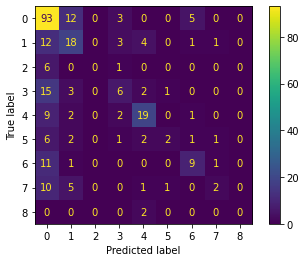

In [17]:
cm_test = confusion_matrix(y_test, test_preds)
ConfusionMatrixDisplay(cm_test).plot()

In [18]:
y = core_preds_df["label"]
pred1 = core_preds_df["pred_mode1"]
pred2 = core_preds_df["pred_mode2"]
pred3 = core_preds_df["pred_mode3"]

In [19]:
((pred1 == y) | (pred2 == y) | (pred3 == y)).sum() / (len(pred1))

0.776173285198556